In [28]:
import dask.array as da
import dask.dataframe as dd
import dask
import pandas as pd
import numpy as np
from constants import DEBUG_POSTGRESQL_PARQUET_FOLDER
from pathlib import Path
from scipy.sparse import dok_array
import networkx as nx
from tqdm.contrib.concurrent import process_map
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from ddsketch import DDSketch

In [29]:
class QueryTemplateEncoder:
    """
    Why not sklearn.preprocessing.LabelEncoder()?

    - Not all labels (query templates) are known ahead of time.
    - Not that many query templates, so hopefully this isn't a bottleneck.
    """

    def __init__(self):
        self._encodings = {}
        self._inverse = {}
        self._next_label = 1

    def fit(self, labels):
        for label in labels:
            if label not in self._encodings:
                self._encodings[label] = self._next_label
                self._inverse[self._next_label] = label
                self._next_label += 1
        return self

    def transform(self, labels):
        return [self._encodings[label] for label in labels]

    def fit_transform(self, labels):
        return self.fit(labels).transform(labels)

    def inverse_transform(self, encodings):
        return [self._inverse[encoding] for encoding in encodings]


class QtMeta:
    def __init__(self):
        self._think_time_sketch = DDSketch()

    def record(self, think_time):
        self._think_time_sketch.add(think_time)

class DfMeta:
    SESSION_BEGIN = "SESSION_BEGIN"
    SESSION_END = "SESSION_END"

    def __init__(self):
        self.qtms = {}
        self.qt_enc = QueryTemplateEncoder()
        # Dummy tokens for session begin and session end.
        self.qt_enc.fit([self.SESSION_BEGIN, self.SESSION_END, pd.NA])

        # networkx dict_of_dicts format.
        self.transition_sessions = {}
        self.transition_txns = {}

    def augment(self, df):
        # Augment the dataframe while updating internal state.

        # Encode the query templates.
        df["query_template_enc"] = self.qt_enc.fit_transform(df["query_template"])

        # Lagged time.
        df["think_time"] = (df["log_time"] - df["log_time"].shift(1)).shift(-1).dt.total_seconds()

        def record_thinks(row):
            qt_enc = row["query_template_enc"]
            think_time = row["think_time"]
            self.qtms[qt_enc] = self.qtms.get(qt_enc, QtMeta())
            self.qtms[qt_enc].record(think_time)
        df.apply(record_thinks, axis=1)

        self._update_transition_dict(self.transition_sessions, self._compute_transition_dict("session_id"))
        self._update_transition_dict(self.transition_txns, self._compute_transition_dict("virtual_transaction_id"))

    def visualize(self, target):
        assert target in ["sessions", "txns"], f"Bad target: {target}"

        if target == "sessions":
            transitions = self.transition_sessions
        else:
            assert target == "txns"
            transitions = self.transition_txns

        def rewrite(s):
            l = 24
            return "\n".join(s[i:i + l] for i in range(0, len(s), l))

        G = nx.DiGraph(transitions)
        nx.relabel_nodes(G, {k: rewrite(dfm.qt_enc.inverse_transform([k])[0]) for k in G.nodes}, copy=False)
        AG = nx.drawing.nx_agraph.to_agraph(G)
        AG.layout("dot")
        AG.draw(f"{target}.pdf")

    @staticmethod
    def _update_transition_dict(current, other):
        for src in other:
            current[src] = current.get(src, {})
            for dst in other[src]:
                current[src][dst] = current[src].get(dst, {"weight": 0})
                current[src][dst]["weight"] += other[src][dst]["weight"]
                # Set the label for printing.
                current[src][dst]["label"] = current[src][dst]["weight"]

    def _compute_transition_dict(self, group_key):
        assert group_key in ["session_id", "virtual_transaction_id"], f"Unknown group key: {group_key}"

        group_fn = None
        if group_key == "session_id":
            group_fn = self._group_session
        elif group_key == "virtual_transaction_id":
            group_fn = self._group_txn
        assert group_fn is not None, "Forgot to add a case?"

        transitions = {}
        groups = df.groupby(group_key)
        chunksize = max(1, len(groups) // cpu_count())
        grouped = process_map(group_fn, groups, chunksize=chunksize, desc=f"Grouping on {group_key}.", disable=True)
        # TODO(WAN): Parallelize.
        for group_id, group_qt_encs in tqdm(grouped, desc=f"Computing transition matrix for {group_key}.",
                                            disable=True):
            for transition in zip(group_qt_encs, group_qt_encs[1:]):
                src, dst = transition
                transitions[src] = transitions.get(src, {})
                transitions[src][dst] = transitions[src].get(dst, {"weight": 0})
                transitions[src][dst]["weight"] += 1
                transitions[src][dst]["label"] = transitions[src][dst]["weight"]
        return transitions

    def _group_txn(self, item):
        group_id, df = item
        df = df.sort_values(["log_time", "session_line_num"])
        qt_encs = df["query_template_enc"].values
        return group_id, qt_encs

    def _group_session(self, item):
        group_id, df = item
        df = df.sort_values(["log_time", "session_line_num"])
        qt_encs = df["query_template_enc"].values
        qt_encs = np.concatenate([
            self.qt_enc.transform([self.SESSION_BEGIN]),
            qt_encs,
            self.qt_enc.transform([self.SESSION_END]),
        ])
        return group_id, qt_encs


dfm = DfMeta()
for pq_file in tqdm(sorted(list(Path(DEBUG_POSTGRESQL_PARQUET_FOLDER).glob("*.parquet"))),
                    desc="Reading Parquet files.",
                    disable=True):
    df = pd.read_parquet(pq_file)
    df["query_template"] = df["query_template"].replace("", np.nan)
    dropna_before = df.shape[0]
    df = df.dropna(subset=["query_template"])
    dropna_after = df.shape[0]
    print(f"Dropped {dropna_before - dropna_after} empty query templates in {pq_file}.")
    dfm.augment(df)
    break
# dfm.visualize("sessions")
# dfm.visualize("txns")

Dropped 34 empty query templates in /tmp/meowquet/postgres_0.csv.parquet.


In [56]:
{dfm.qt_enc.inverse_transform([i])[0]: dfm.qtms[i]._think_time_sketch.get_quantile_value(0.5) for i in range(4,47)}

{'BEGIN': 0,
 'SET extra_float_digits = $1': 0,
 'SET application_name = $1': 0,
 'COMMIT': 0.0009974781146369917,
 'select current_schema()': 0.012904295852863203,
 'SELECT NULL AS TABLE_CAT, n.nspname AS TABLE_SCHEM, c.relname AS TABLE_NAME, CASE n.nspname ~ $1 OR n.nspname = $2 WHEN true THEN CASE WHEN n.nspname = $3 OR n.nspname = $4 THEN CASE c.relkind WHEN $5 THEN $6 WHEN $7 THEN $8 WHEN $9 THEN $10 ELSE NULL END WHEN n.nspname = $11 THEN CASE c.relkind WHEN $12 THEN $13 WHEN $14 THEN $15 ELSE NULL END ELSE CASE c.relkind WHEN $16 THEN $17 WHEN $18 THEN $19 WHEN $20 THEN $21 WHEN $22 THEN $23 WHEN $24 THEN $25 ELSE NULL END END WHEN false THEN CASE c.relkind WHEN $26 THEN $27 WHEN $28 THEN $29 WHEN $30 THEN $31 WHEN $32 then $33 WHEN $34 THEN $35 WHEN $36 THEN $37 WHEN $38 THEN $39 WHEN $40 THEN $41 WHEN $42 THEN $43 ELSE NULL END ELSE NULL END AS TABLE_TYPE, d.description AS REMARKS, $44 as TYPE_CAT, $45 as TYPE_SCHEM, $46 as TYPE_NAME, $47 AS SELF_REFERENCING_COL_NAME, $48 AS R

In [76]:
begin_times = df[df["query_template"] == "BEGIN"].set_index("log_time").resample("S").size()

In [100]:
ndf = begin_times.to_frame()
ndf = ndf.tz_localize(None).reset_index().rename(columns={"log_time": "ds", 0: "y"})
ndf

,ds,y
0,2022-04-06 11:53:53,1
1,2022-04-06 11:53:54,169
2,2022-04-06 11:53:55,330
3,2022-04-06 11:53:56,379
4,2022-04-06 11:53:57,391
...,...,...
59,2022-04-06 11:54:52,421
60,2022-04-06 11:54:53,461
61,2022-04-06 11:54:54,426
62,2022-04-06 11:54:55,427


In [101]:
from neuralprophet import NeuralProphet

m = NeuralProphet()
test = m.fit(ndf, freq="S")

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 357


  0%|          | 0/193 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.07E-01, min: 1.15E+01


  0%|          | 0/193 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.23E+01, min: 4.87E+00


  0%|          | 0/193 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.07E-01, min: 1.98E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.05E+00
Epoch[357/357]: 100%|██████████| 357/357 [00:01<00:00, 204.09it/s, SmoothL1Loss=0.0052, MAE=25.3, RMSE=42, RegLoss=0]   


In [108]:
ndf_future = m.make_future_dataframe(ndf, periods=900)
ndf_future

,ds,y
0,2022-04-06 11:54:57,None
1,2022-04-06 11:54:58,None
2,2022-04-06 11:54:59,None
3,2022-04-06 11:55:00,None
4,2022-04-06 11:55:01,None
...,...,...
895,2022-04-06 12:09:52,None
896,2022-04-06 12:09:53,None
897,2022-04-06 12:09:54,None
898,2022-04-06 12:09:55,None


WARNING - (py.warnings._showwarnmsg) - /home/cmu-db-nuc-wan/.virtualenvs/default/lib/python3.8/site-packages/neuralprophet/forecaster.py:395: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



Forecast


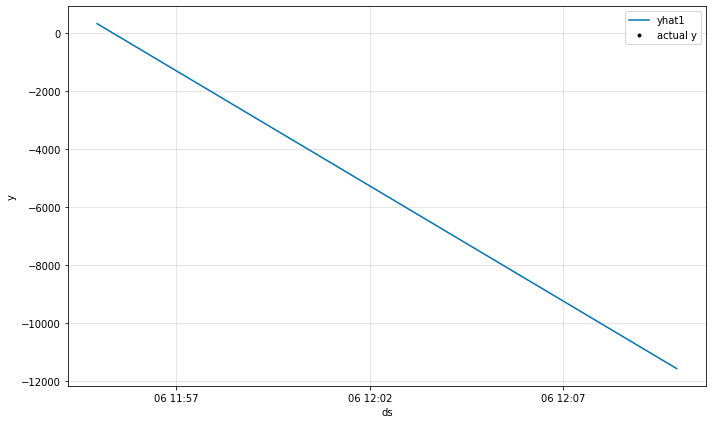

Components


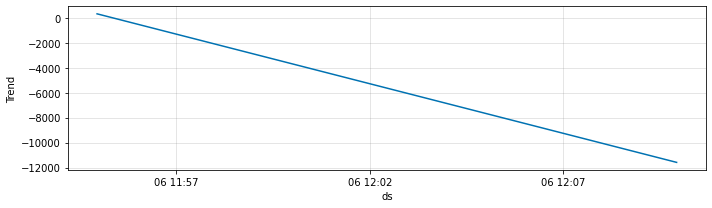

Params


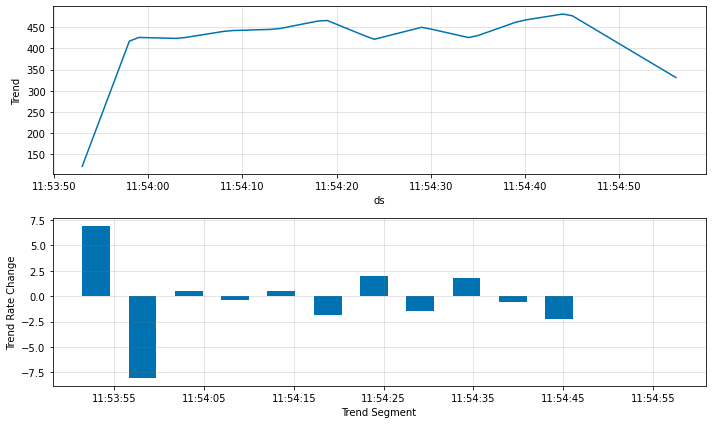

In [111]:
pred_df = ndf_future
nforecast = m.predict(pred_df)
print("Forecast")
fig_forecast = m.plot(nforecast)
plt.show()
print("Components")
fig_components = m.plot_components(nforecast)
plt.show()
print("Params")
fig_model = m.plot_parameters()
plt.show()

In [ ]:
G = G_old

while True:
    deg_out_one = set([node for node, degree in G.out_degree if degree == 1])
    deg_in_one = set([node for node, degree in G.in_degree if degree == 1])
    contraction_candidates = list(deg_in_one & deg_out_one)

    for node in contraction_candidates:
        pred = list(G.predecessors(node))[0]
        succ = list(G.successors(node))[0]
        predw = G.in_edges[pred, node]["weight"]
        succw = G.out_edges[node, succ]["weight"]

        # Try to merge the node with its successor.
        if succ in deg_out_one and predw == succw:
            nx.contracted_nodes(G, node, succ, self_loops=False, copy=False)
            nx.relabel_nodes(G, {node: f"{node},{succ}"}, copy=False)
            break
    else:
        break
print(G)

In [ ]:
fig = plt.figure(figsize=(24, 36))
# pos = nx.nx_agraph.graphviz_layout(G)
pos = nx.spring_layout(G, weight=None)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.savefig("sessions_contracted.pdf")